# Activity Transition Matrices

In [31]:
import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
import seaborn as sns
from utils import *
import saving as sv
from scipy.spatial import distance
from scipy.stats import pearsonr,zscore
import itertools as it

from atms import Transprob, transprob
import avalanches as av

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
#Here the path to data 
path_results='C:/Users/matte/OneDrive/Documenti/matteo/sorciere_results/'
path_figures='C:/Users/matte/OneDrive/Documenti/matteo/sorciere_results/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

sound_list=['speech','music', 'rest']

#colors for plotting 
col_s='#8CCC94'
col_m='#FCAC74'
col_r='#6CA4CC'

colors={}
colors['rest'] = col_r
colors['speech'] = col_s
colors['music'] = col_m

#Here uploading subject and sound list
sound_list=['rest','music','speech']

subject_list = sv.loading(path+'subject_list')

cha_i=sv.loading(path+'sorciere_utils/channels_dic_H_non_H_left_right')


In [2]:


#PARAMETERS

subject_list=subject_list
final_channels_without_H={}
final_channels_H={}
final_channels_all={}
dataused='all'

zdata={}

for isub, subject in enumerate(subject_list):
    
    zdata[subject]={}
    
    for sound in sound_list:
    
        ## Load the data from the HDF fil
        #print(subject, isub)    
        #Loading the data
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        
        #dictionaries with subjects ad keys and channels names
        final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in cha_i[subject]['non_H']]
        final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in cha_i[subject]['H']]
        final_channels_all[subject]=clean_chnames

        #The final channels that we used
        final_channels=clean_chnames

        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus

        if dataused=='H':
            clean = np.delete(clean, cha_i[subject]['non_H'], axis=0)

        #only the channels not in the helsch gyrus
        elif dataused=='non_H':
            clean = np.delete(clean, cha_i[subject]['H'], axis=0)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)



In [5]:
zb={}
for sound in sound_list:
    zb[sound]={}

    for subject in subject_list:
        thres=np.percentile(zdata[subject]['rest'], 99)

        aval=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        zb[sound][subject]=aval['Zbin']

In [10]:
trM=np.zeros((19,3), dtype=object)   
trM_sy=np.zeros((19,3), dtype=object)   
for isub, subject in enumerate(subject_list):
    
    trm_speech = Transprob(zb['speech'][subject])
    trM[isub,0]=trm_speech
    trM_sy[isub,0]=(trm_speech+trm_speech.T)*0.5
   
    trm_music = Transprob(zb['music'][subject])
    trM[isub,1]=trm_music
    trM_sy[isub,1]=(trm_music+trm_music.T)*0.5
 
    trm_rest = Transprob(zb['rest'][subject])
    trM[isub,2]=trm_rest
    trM_sy[isub,2]=(trm_rest+trm_rest.T)*0.5 

       

rest


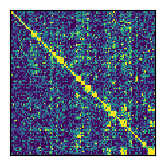

music


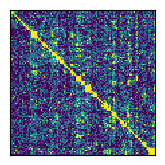

speech


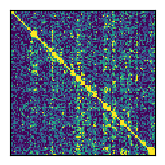

In [11]:
vm=0.2
cl='viridis'
colorbar=False

for s, sound in enumerate(sound_list):
    
    a,b=0.001,0.004
    print(sound)
    plt.figure(figsize=(1.75,1.75))
    plt.imshow(trM[1,s],cmap=cl,interpolation='nearest', vmin=a, vmax=b)
    
    plt.yticks([])
    plt.xticks([])
    if sound=='rest' and colorbar==True:
        plt.colorbar(orientation = 'horizontal', shrink=1, aspect=5)
    plt.tight_layout()

    #saving the figure:
    plt.savefig(path_figures+'example_ATM_colorbar'+sound+'_'+dataused+'.png', dpi=600)

    plt.show()

In [12]:
dist_sp_mu = {}
dist_sp_re = {}
dist_re_mu = {}

dist_s_m = []
dist_s_r = []
dist_m_r = []

for isub,subject in enumerate(subject_list):
    
    dist_sp_mu[subject] = {}
    dist_sp_re[subject] = {}
    dist_re_mu[subject] = {}
    
    indici_mix  = list(product(cha_i[subject]['H'], cha_i[subject]['H']))
    idx_i, idx_j = zip(*indici_mix)

    #sp = trM_sy[isub,0][idx_i,idx_j]
    #mu = trM_sy[isub,1][idx_i,idx_j]
    #re = trM_sy[isub,2][idx_i,idx_j]
    
    sp = trM[isub,0]
    mu = trM[isub,1]
    re = trM[isub,2]
    
    # sp = zscore(np.triu(0.5*(sp+sp.T),0).flatten())
    # mu = zscore(np.triu(0.5*(mu+mu.T),0).flatten())
    # re = zscore(np.triu(0.5*(re+re.T),0).flatten())

    #sp = zscore(sp.flatten())
    #mu = zscore(mu.flatten())
    #re = zscore(re.flatten())


    
    dist_sp_mu[subject]['correlation'] = corrATM(sp,mu)
    dist_sp_re[subject]['correlation'] = corrATM(sp,re)
    dist_re_mu[subject]['correlation'] = corrATM(mu,re)
    


(0.25, 1.35)

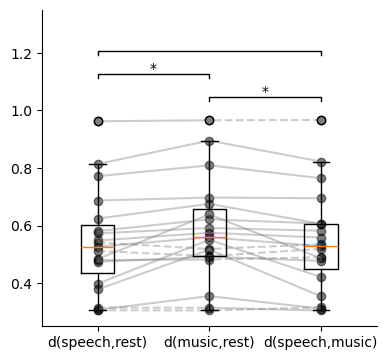

In [20]:
dist_sp_re1=[]
dist_sp_mu1=[]
dist_re_mu1=[]

for subject in subject_list:
    dist_sp_re1.append(dist_sp_re[subject]['correlation'])
    dist_sp_mu1.append(dist_sp_mu[subject]['correlation'])
    dist_re_mu1.append(dist_re_mu[subject]['correlation'])


C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}
#C2 = {     'sr': '#803b7f',    'mr': '#c0896f',    'sm': '#b6d12d'}
plt.figure(figsize=(2.4*1.6,2.8*1.25))

#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[dist_sp_re1,dist_re_mu1,dist_sp_mu1]#[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in range(len(dist_sp_mu1)):
    spmu=dist_sp_mu1[i]
    remu=dist_re_mu1[i]
    spre=dist_sp_re1[i]

    plt.scatter(1,spre,color='k',alpha=.5)#color=C2['sr']
    plt.scatter(2,remu,color='k',alpha=.5)#color=C2['mr'],
    plt.scatter(3,spmu,color='k',alpha=.5)#color=C2['sm']

    # plt.scatter(1,spre,color=C1['s'],alpha=.5)
    # plt.scatter(2,remu,color=C1['m'],alpha=.5)
    # plt.scatter(3,spmu,color=C1['m'],alpha=.9)
    # plt.scatter(1,spre,color=C1['r'],alpha=.5)
    # plt.scatter(2,remu,color=C1['r'],alpha=.5)
    # plt.scatter(3,spmu,color=C1['s'],alpha=.5)
    if spre-remu<0:
        plt.plot([1,2],[spre,remu],color='grey',alpha=0.4)
    else:
        plt.plot([1,2],[spre,remu],color='grey',alpha=0.4,linestyle='--')

    if spmu-remu<0:
        plt.plot([3,2],[spmu,remu],color='grey',alpha=0.4)
    else:
        plt.plot([3,2],[spmu,remu],color='grey',alpha=0.4,linestyle='--')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.boxplot(box_plot_data,patch_artist=False,labels=['d(speech,rest)','d(music,rest)','d(speech,music)'])
psrmr=stats.wilcoxon(dist_sp_re1,dist_re_mu1)[1]
psrsm=stats.wilcoxon(dist_sp_re1,dist_sp_mu1)[1]
pmrsm=stats.wilcoxon(dist_re_mu1,dist_sp_mu1)[1]

# p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
# print('Gio test  ', p)
# print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
# print('p_value music - speech ', pp)
# print('p_value music - rest ', psr)
# print('p_value music - rest ', pmr)

to_min1=np.array([dist_sp_re1,dist_sp_mu1,dist_re_mu1])
bottom1, top1 = np.min(to_min1), np.max(to_min1)
bars_diff(0.03, bottom1, top1,height=3)
bars_diff(0.1, bottom1, top1,x1=1,x2=3,height=4.5)
bars_diff(0.03, bottom1, top1,x1=2,x2=3,height=1.5)
plt.tight_layout(pad=0.35)
plt.ylim((0.25,1.35))

# plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
# plt.show()
# plt.close()

$\rho_{speech,rest}$
('$H,H$', '$noH,noH$')
WilcoxonResult(statistic=8.0, pvalue=0.0004633944245426167)
-3.5010698191470717
('$H,H$', '$H,noH$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$H,H$', '$noH,H$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$noH,noH$', '$H,noH$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$noH,noH$', '$noH,H$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$H,noH$', '$noH,H$')
WilcoxonResult(statistic=43.0, pvalue=0.03638546131456511)
-2.0925934551223877


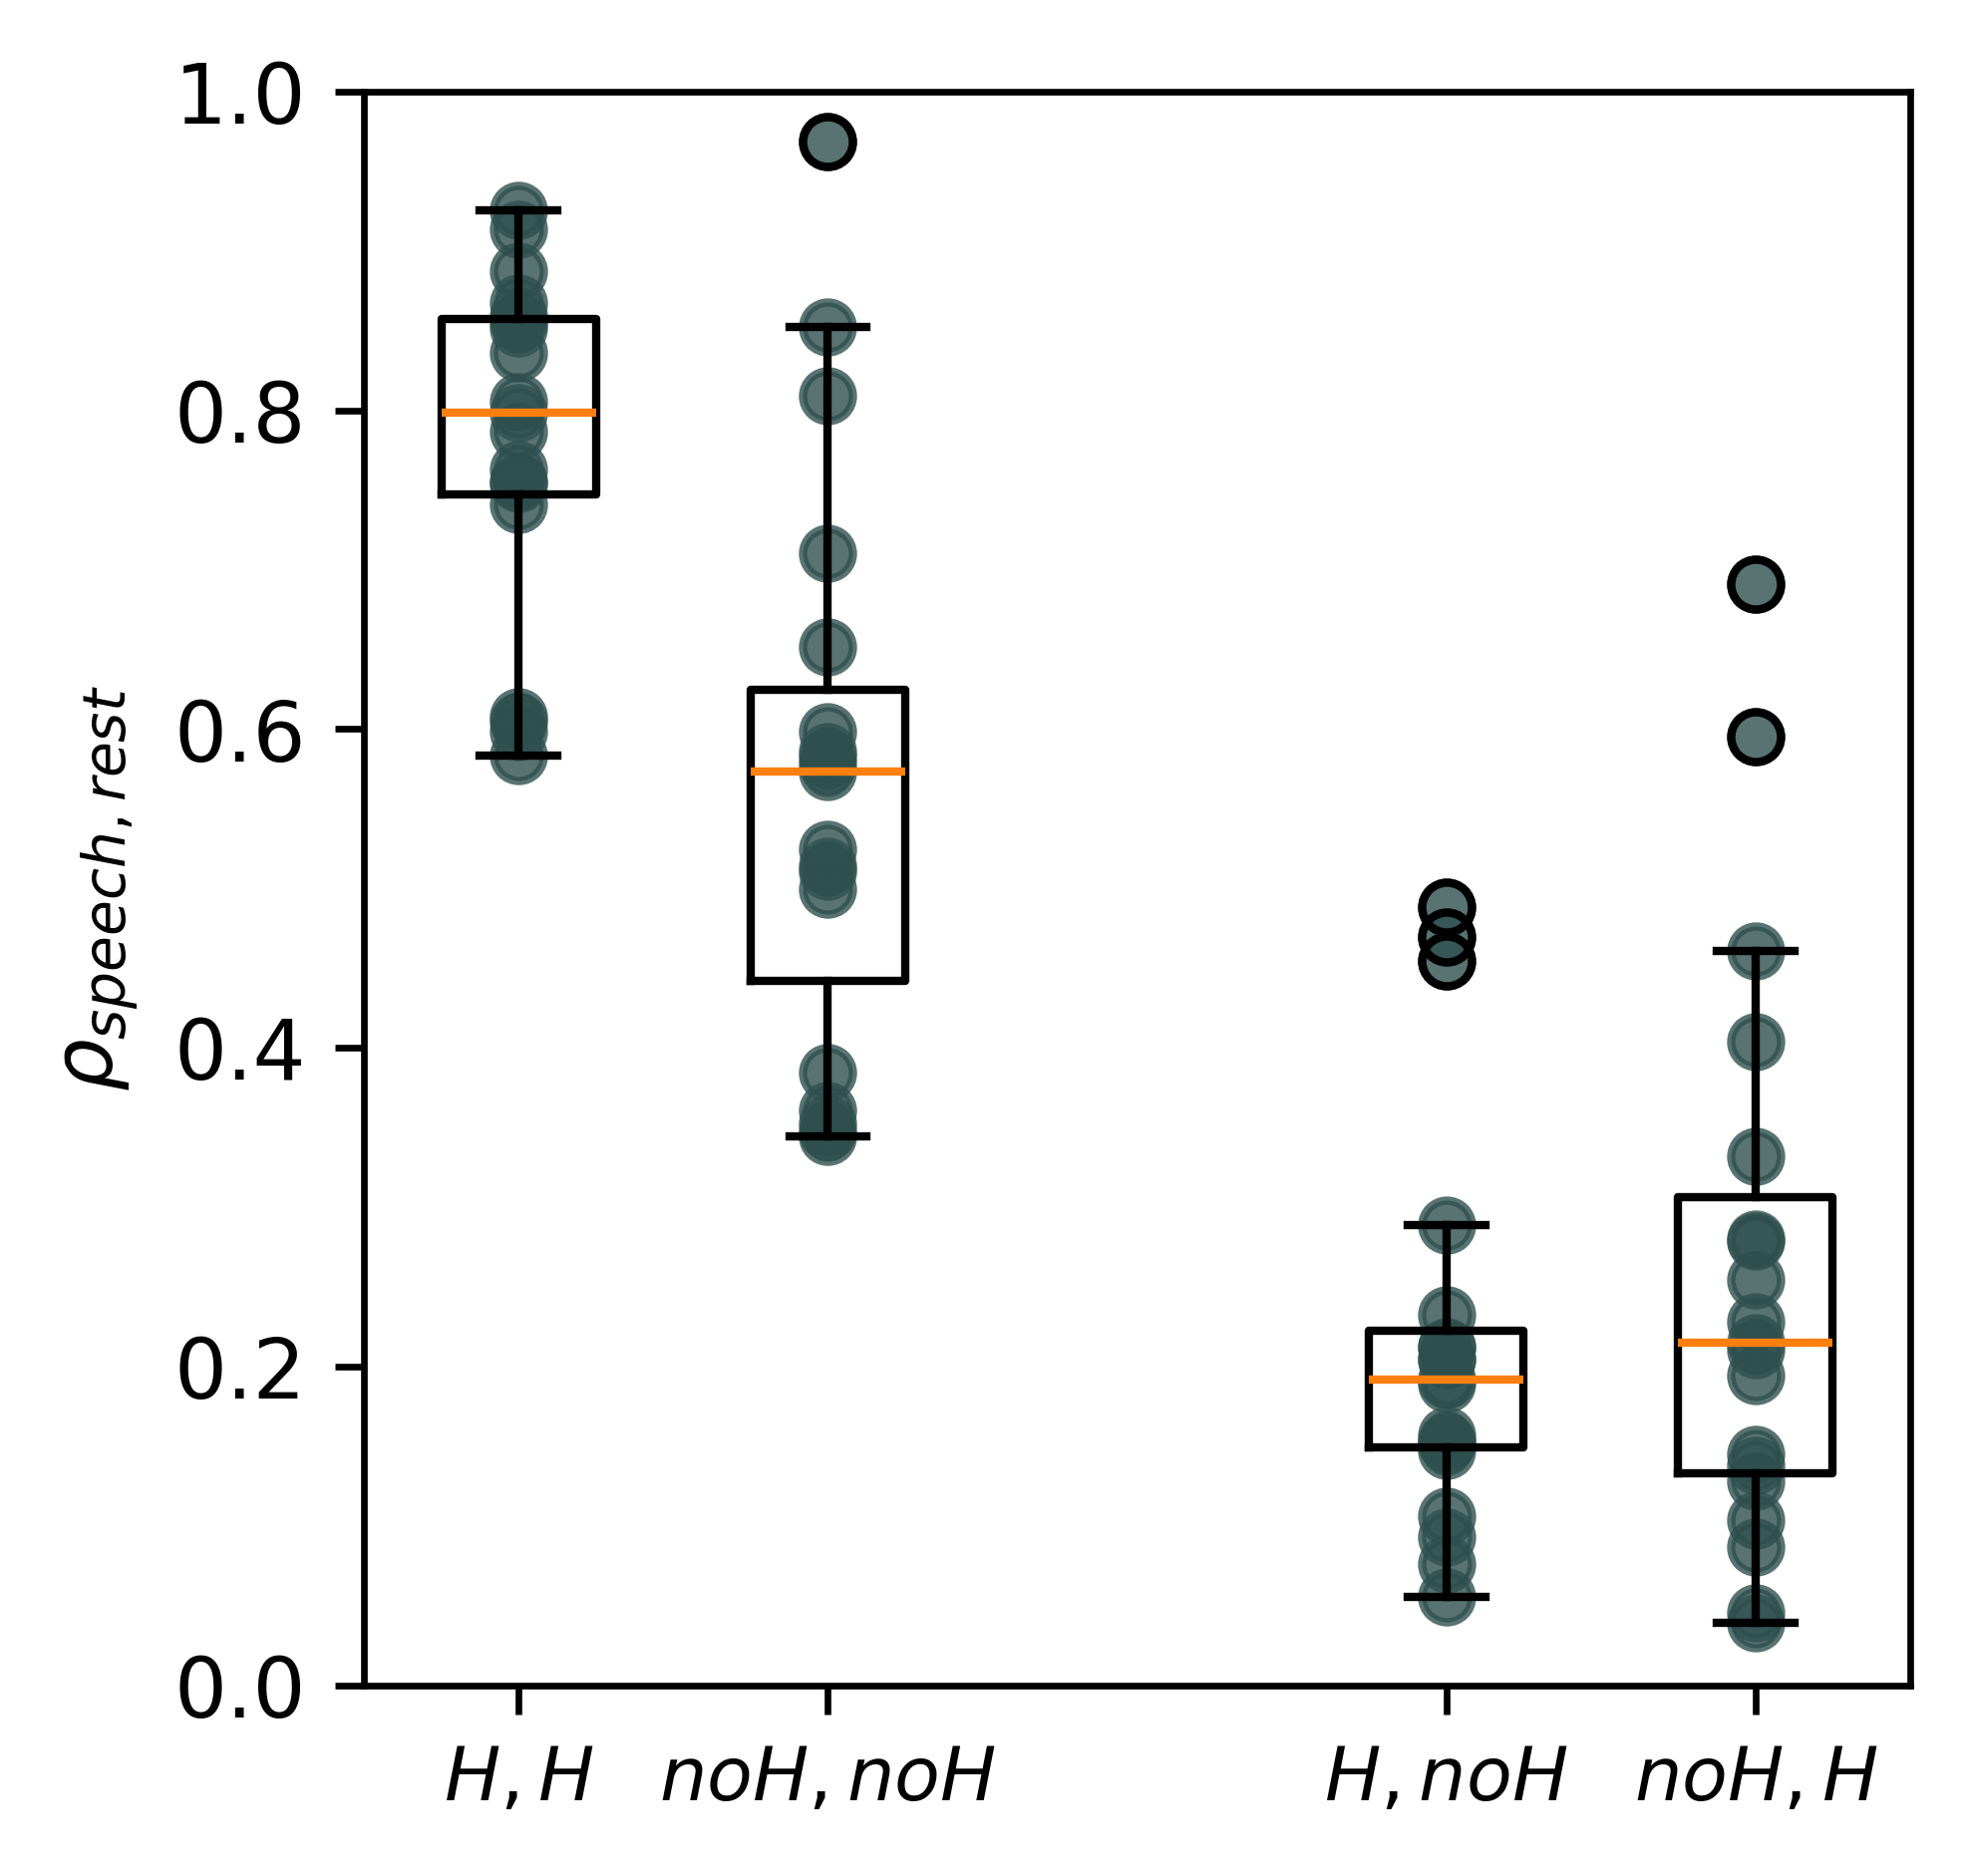

$\rho_{music,rest}$
('$H,H$', '$noH,noH$')
WilcoxonResult(statistic=14.0, pvalue=0.0011156286211977205)
-3.2596167281714115
('$H,H$', '$H,noH$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$H,H$', '$noH,H$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$noH,noH$', '$H,noH$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$noH,noH$', '$noH,H$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$H,noH$', '$noH,H$')
WilcoxonResult(statistic=67.0, pvalue=0.2598350470503199)
-1.1267810912197471


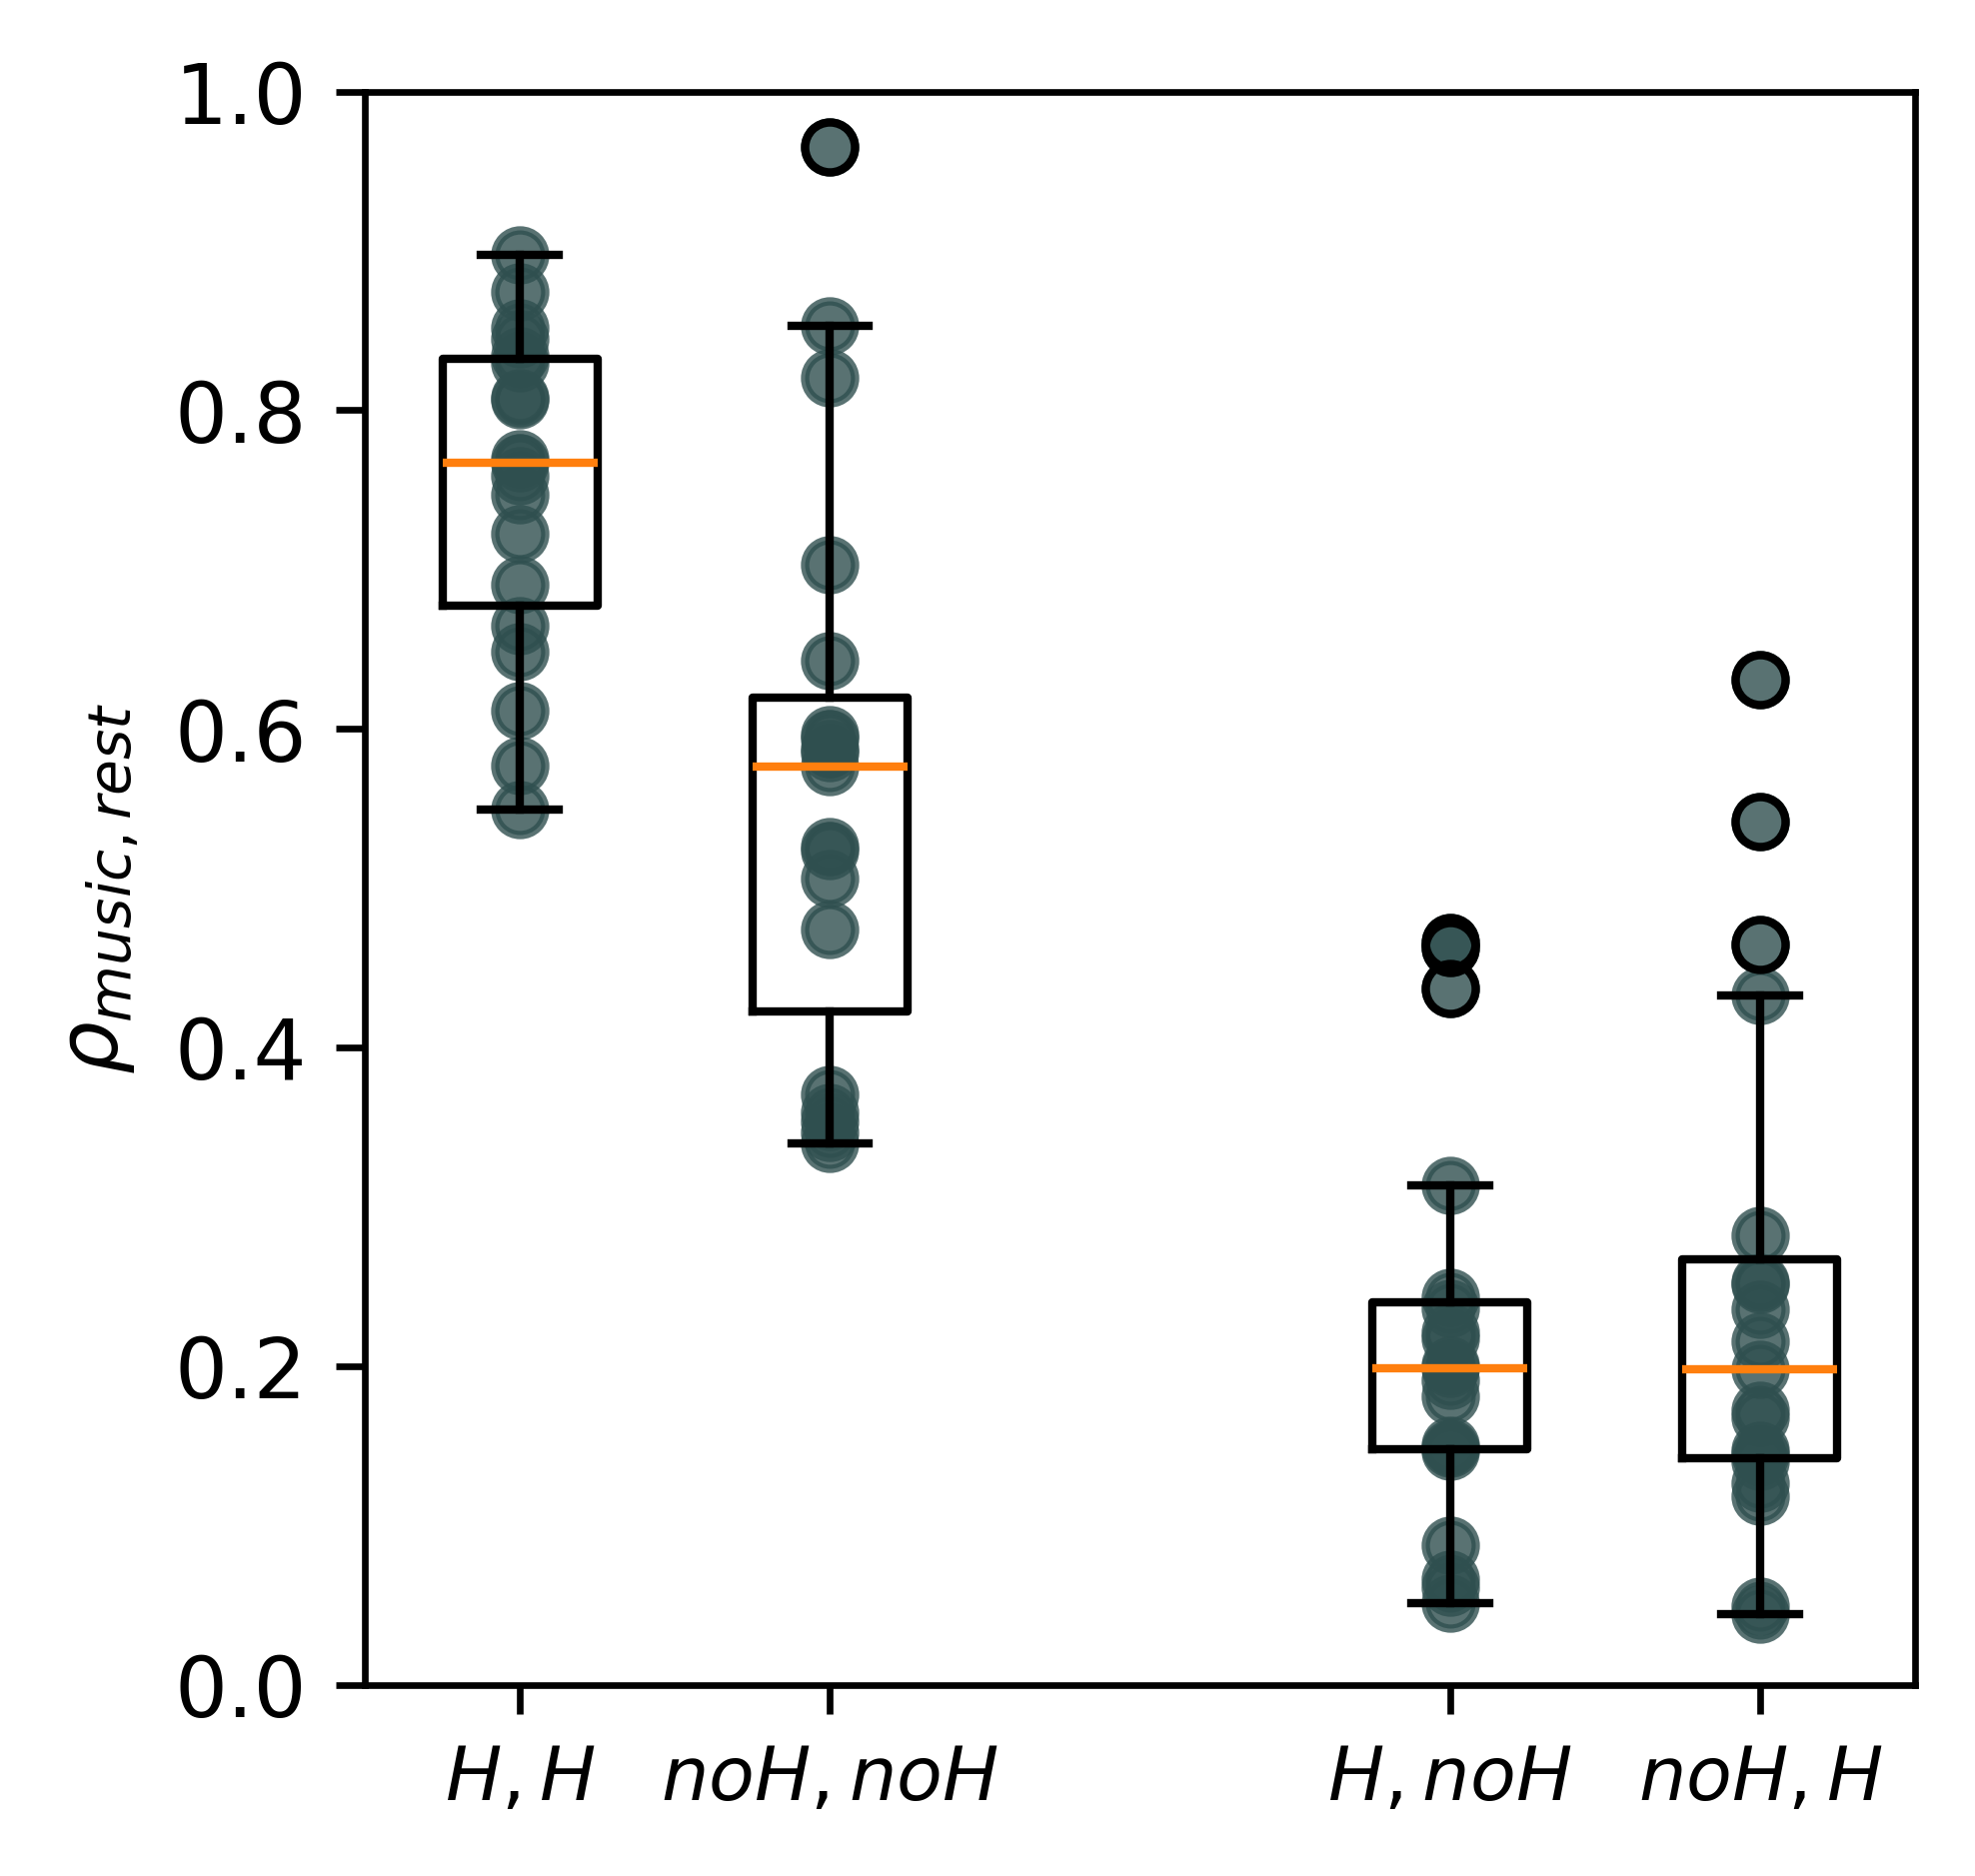

$\rho_{speech,music}$
('$H,H$', '$noH,noH$')
WilcoxonResult(statistic=17.0, pvalue=0.001695889903397192)
-3.1388901826835816
('$H,H$', '$H,noH$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$H,H$', '$noH,H$')
WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)
-3.8230072737812852
('$noH,noH$', '$H,noH$')
WilcoxonResult(statistic=1.0, pvalue=0.00015509577279577017)
-3.782765091952008
('$noH,noH$', '$noH,H$')
WilcoxonResult(statistic=2.0, pvalue=0.0001821819171706161)
-3.7425229101227315
('$H,noH$', '$noH,H$')
WilcoxonResult(statistic=52.0, pvalue=0.08355636667535958)
-1.7304138186588975


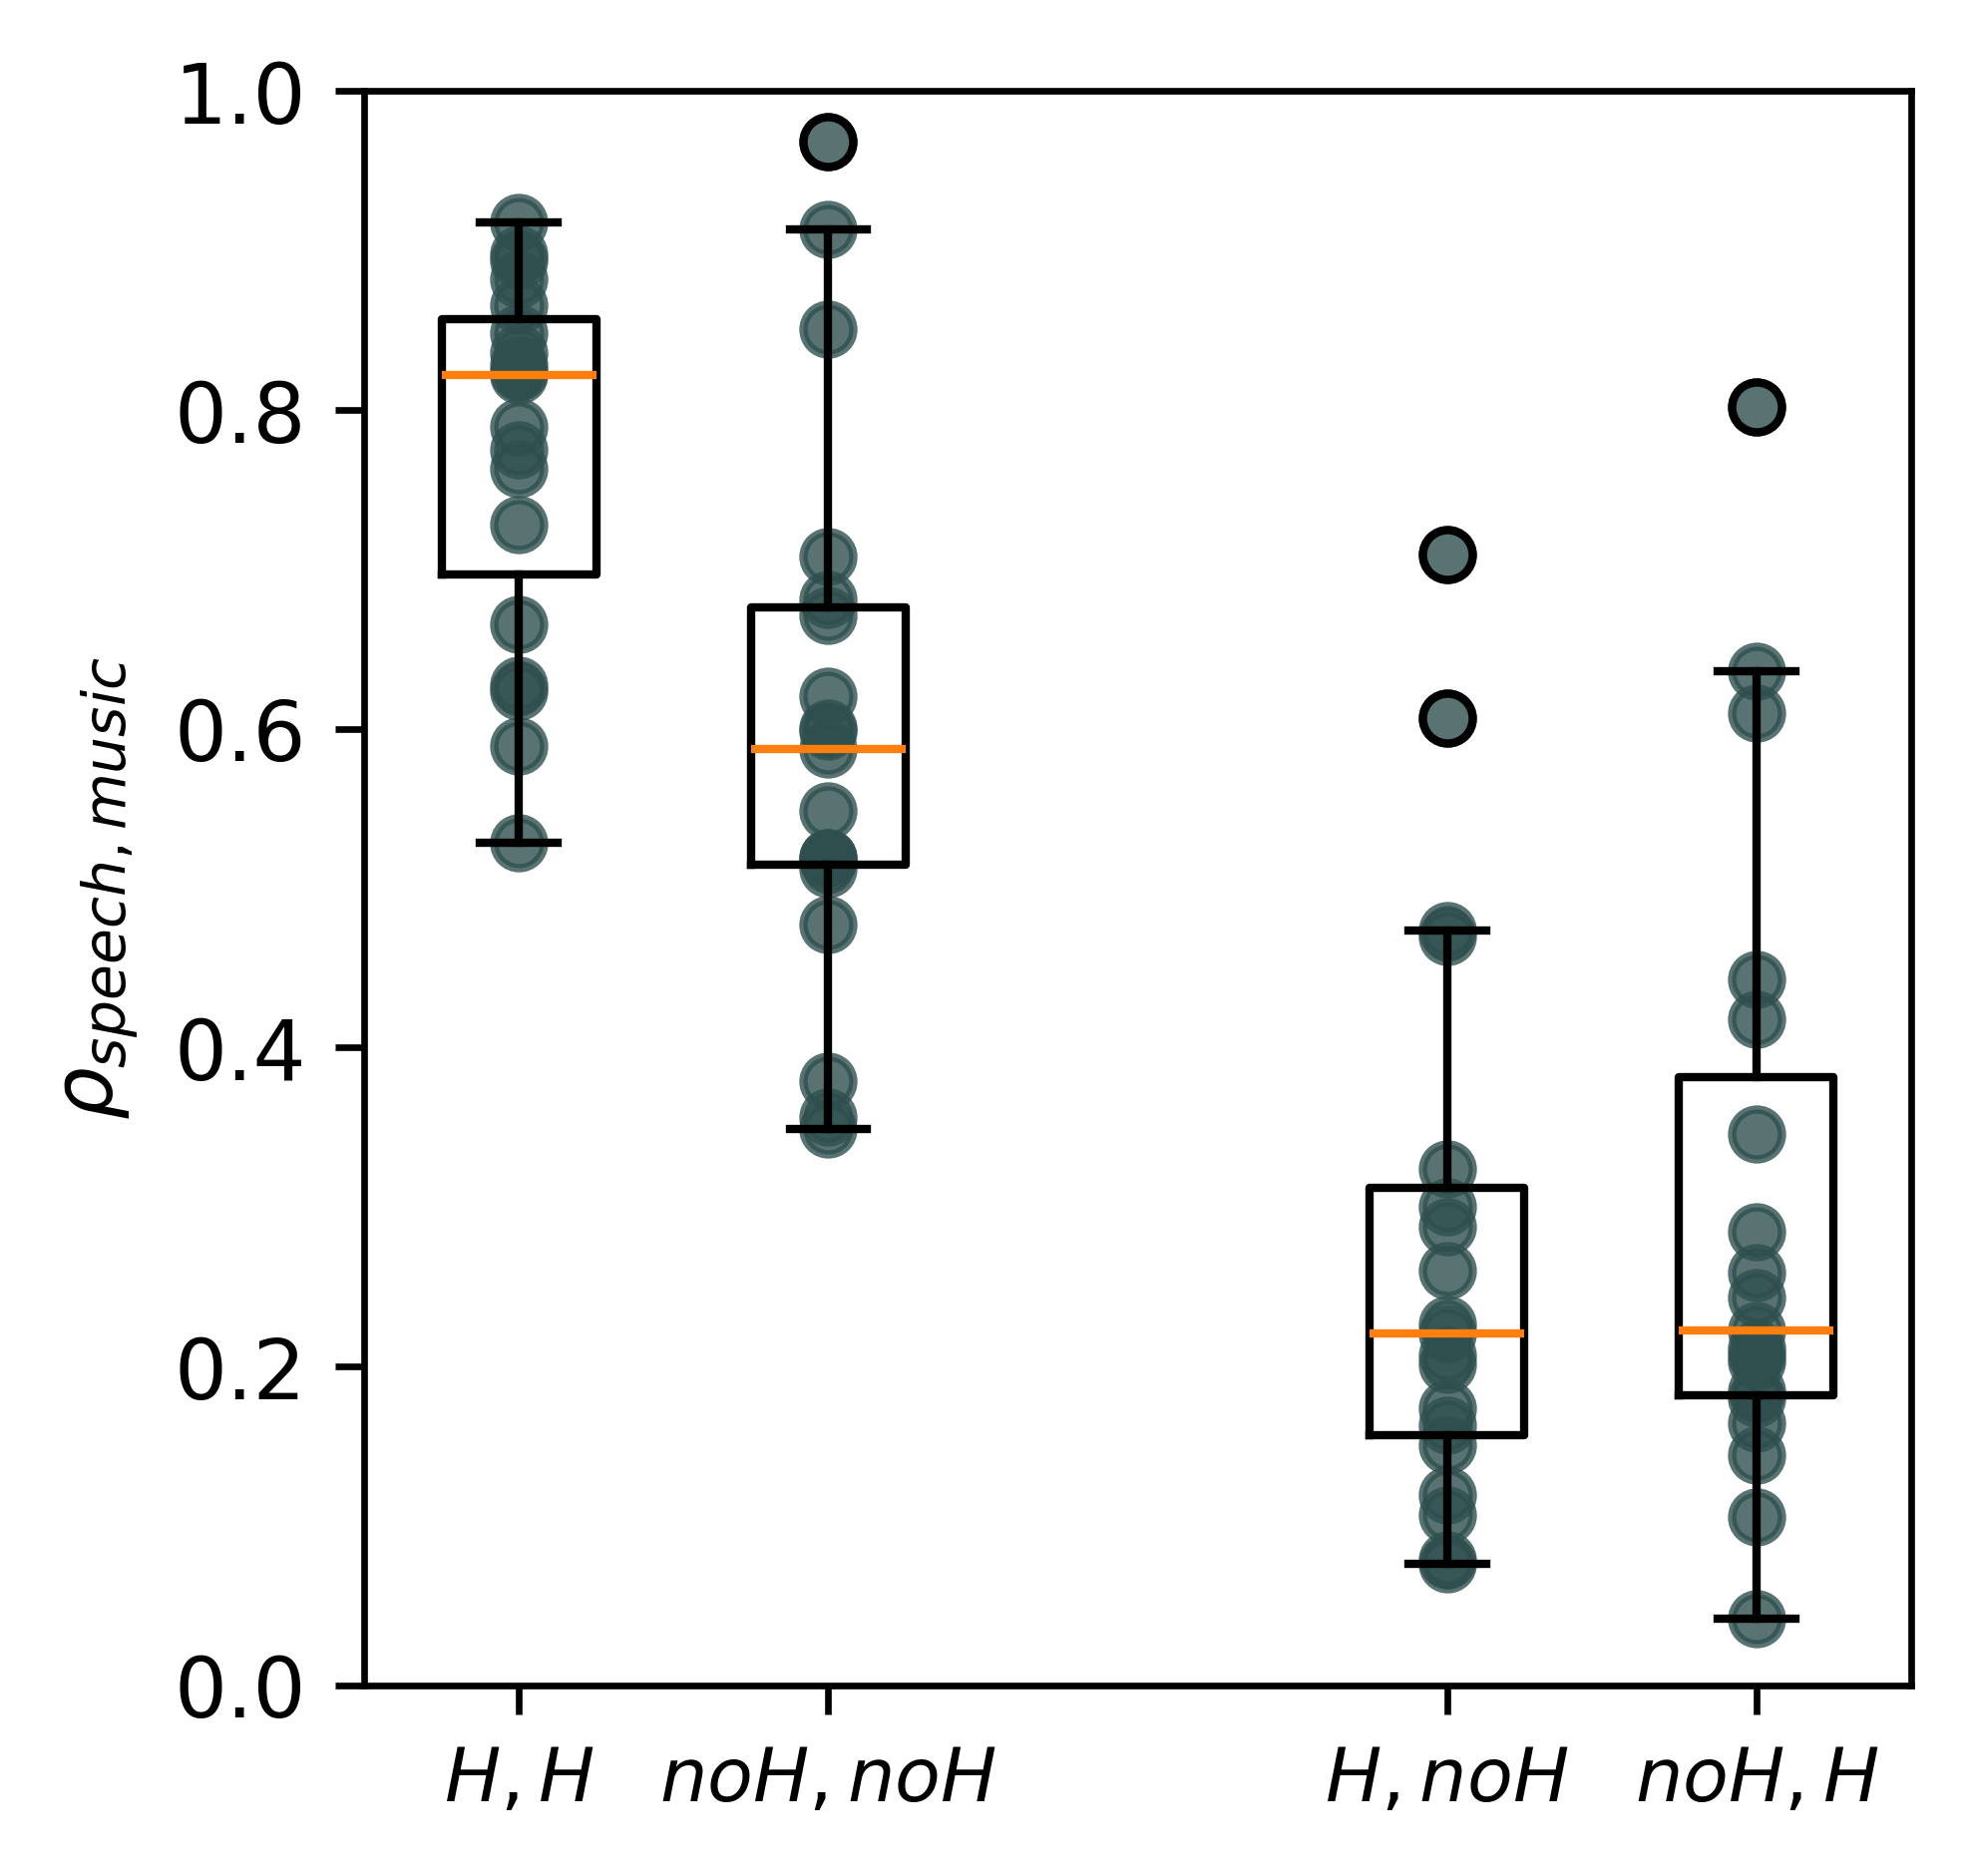

In [33]:
SP_MU = []
SP_RE = []
RE_MU = []

conditions = list(product(*[['H','non_H']],repeat=2))

for cond in conditions:
    
    dist_sp_mu = {}
    dist_sp_re = {}
    dist_re_mu = {}
    dist_sp_mu1 = []
    dist_sp_re1 = []
    dist_re_mu1 = []
    
    for isub,subject in enumerate(subject_list):
        
        indici_mix  = list(product(cha_i[subject][cond[0]], cha_i[subject][cond[1]]))
        idx_i, idx_j = zip(*indici_mix)
        
        sp = trM[isub,0][idx_i,idx_j]
        mu = trM[isub,1][idx_i,idx_j]#
        re = trM[isub,2][idx_i,idx_j]#
        
        sp = np.reshape(sp,(len(cha_i[subject][cond[0]]),len(cha_i[subject][cond[1]])))
        mu = np.reshape(mu,(len(cha_i[subject][cond[0]]),len(cha_i[subject][cond[1]])))
        re = np.reshape(re,(len(cha_i[subject][cond[0]]),len(cha_i[subject][cond[1]])))

        dist_sp_mu[subject] = corrATM(sp,mu)#abs(pearsonr(sp,mu)[0])
        dist_sp_re[subject] = corrATM(sp,re)#abs(pearsonr(sp,re)[0])
        dist_re_mu[subject] = corrATM(mu,re)#abs(pearsonr(mu,re)[0])
        
        dist_sp_mu1.append(dist_sp_mu[subject])
        dist_sp_re1.append(dist_sp_re[subject])
        dist_re_mu1.append(dist_re_mu[subject])
    
    SP_MU.append(dist_sp_mu1)
    SP_RE.append(dist_sp_re1)
    RE_MU.append(dist_re_mu1)

#%% plot elemnti mix

C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}
#C2 = {     'sr': '#803b7f',    'mr': '#c0896f',    'sm': '#b6d12d'}

distances = [SP_MU,SP_RE,RE_MU]
labels=[r"$\rho_{speech,rest}$",r"$\rho_{music,rest}$",r"$\rho_{speech,music}$"]

l=0
for d in distances:
    
    plt.figure(figsize=(3,3),dpi=600)
    
    box_plot_data=[d[0],d[3],[],d[2],d[1]]
    
    for i in range(len(dist_sp_mu1)):
        spmu=d[0][i]
        remu=d[1][i]
        spre=d[2][i]    
        cccp=d[3][i]
        
        plt.scatter(1,spmu,color='darkslategrey',alpha=.8)#color=C2['sr']
        plt.scatter(5,remu,color='darkslategrey',alpha=.8)#color=C2['mr'],
        plt.scatter(4,spre,color='darkslategrey',alpha=.8)#color=C2['sm']
        plt.scatter(2,cccp,color='darkslategrey',alpha=.8)#color=C2['sm']

    
    plt.boxplot(box_plot_data,patch_artist=False,labels=['$H,H$','$noH,noH$','','$H,noH$','$noH,H$'])
    plt.xticks(fontsize=9)

    li=['$H,H$','$noH,noH$','$H,noH$','$noH,H$']
    ll = list(it.combinations([li[0],li[1],li[2],li[3]],2))
    
    print(labels[l])
    gg = list(it.combinations([d[0],d[3],d[1],d[2]],2))
    
    k=0
    for g in gg:
        print(ll[k])
        print(stats.wilcoxon(g[0],g[1],method='approx'))
        print(stats.wilcoxon(g[0],g[1],method='approx').zstatistic)
        k+=1
        if k >5: k=0
       # print(k)

    plt.tight_layout(pad=0.35)
    plt.ylim((0,1))
    plt.ylabel(labels[l])
    plt.gca().axes.xaxis.get_major_ticks()[2].set_visible(False)
    l+=1
    # plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
    plt.show()
    # plt.close()